# Zero error radius prototyping

- Definition: If absolute error < threshold, then set error = 0

- Binary crossentropy
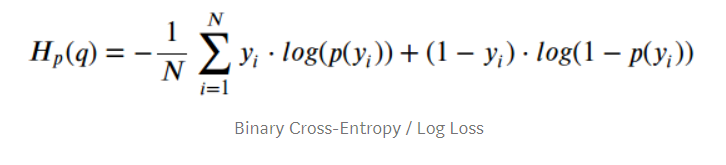

In [ ]:
%load_ext lab_black

In [ ]:
# Toy example with numpy

import numpy as np


def np_zer_replace(target, outout):
    zeros = np.zeros_like(output)
    mask = np.abs(output - target) < 0.1
    out = np.where(mask, target, output)

    print("Output:")
    print(output)
    print("Target:")
    print(target)
    print("Mask")
    print(mask)
    print("Output")
    print(out)

In [ ]:
output = np.array([[0.1, 0.2], [0.22, 0.44]])
target = np.array([[1.0, 0.9], [0.3, 0.3]])

np_zer_masking(target, output)

### Tensorflowisation

In [ ]:
import tensorflow as tf

def zer_replace(target, output):
    zeros = tf.zeros_like(output, dtype=output.dtype)
    zer_threshold = tf.constant(0.1)
    zer_mask = tf.math.less(tf.math.abs(output - target), zer_threshold)
    zer_output = tf.where(zer_mask, target, output)
    return zer_output

In [ ]:
o = tf.convert_to_tensor(output, dtype=tf.float32)
t = tf.convert_to_tensor(target, dtype=tf.float32)

zer_replace(t, o)

### Keras.backend.binary_crossentropy()

In [ ]:
def binary_crossentropy(target, output, from_logits=False):
    """Binary crossentropy between an output tensor and a target tensor.
    Arguments:
      target: A tensor with the same shape as `output`.
      output: A tensor.
      from_logits: Whether `output` is expected to be a logits tensor.
          By default, we consider that `output`
          encodes a probability distribution.
    Returns:
      A tensor.
    """
    if from_logits:
        return nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)

    if not isinstance(output, (ops.EagerTensor, variables_module.Variable)):
        output = _backtrack_identity(output)
    if output.op.type == "Sigmoid":
        # When sigmoid activation function is used for output operation, we
        # use logits from the sigmoid function directly to compute loss in order
        # to prevent collapsing zero when training.
        assert len(output.op.inputs) == 1
        output = output.op.inputs[0]
        return nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)

    epsilon_ = _constant_to_tensor(epsilon(), output.dtype.base_dtype)
    output = clip_ops.clip_by_value(output, epsilon_, 1.0 - epsilon_)

    # Compute cross entropy from probabilities.
    bce = target * math_ops.log(output + epsilon())
    bce += (1 - target) * math_ops.log(1 - output + epsilon())
    return -bce

Because logits in sigmoid output is already computed
To save time, the original code just take it from the output's input (output.op.inputs[0])

``` python
if from_logits:
    return nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)

if not isinstance(output, (ops.EagerTensor, variables_module.Variable)):
    output = _backtrack_identity(output)
if output.op.type == "Sigmoid":
    # When sigmoid activation function is used for output operation, we
    # use logits from the sigmoid function directly to compute loss in order
    # to prevent collapsing zero when training.
    assert len(output.op.inputs) == 1
    output = output.op.inputs[0]
```

## Prototype

In [ ]:
def my_bce(target, output):
    if not isinstance(output, (ops.EagerTensor, variables_module.Variable)):
        output = _backtrack_identity(output)

    # Clip with a tiny constant to avoid zero division
    epsilon_ = _constant_to_tensor(epsilon(), output.dtype.base_dtype)
    output = clip_ops.clip_by_value(output, epsilon_, 1.0 - epsilon_)

    # Replace output by target if value within zero error radius of 0.1
    zer_output = zer_replace(target, output)

    # Compute cross entropy from probabilities.
    bce = target * math_ops.log(zer_output + epsilon())
    bce += (1 - target) * math_ops.log(1 - zer_output + epsilon())
    return -bce

# New addition (Opposite end limit error)

In [ ]:
def zer_replace_v1(target, output, zero_error_radius):
    """Replace output by target if value within zero-error-radius
    """

    # Without zero-error-radius
    zeros = tf.zeros_like(output, dtype=output.dtype)
    zer_threshold = tf.constant(zero_error_radius)
    zer_mask = tf.math.less(tf.math.abs(output - target), zer_threshold)
    zer_output = tf.where(zer_mask, target, output)

    return zer_output

In [ ]:
def zer_replace_v2(target, output, zero_error_radius):
    """Replace output by target if value within zero-error-radius
    Update 200730: also replace opposite end to limit error same as MikeNet
    """

    # Without zero-error-radius
    zeros = tf.zeros_like(output, dtype=output.dtype)
    zer_threshold = tf.constant(zero_error_radius)
    zer_mask = tf.math.less(tf.math.abs(output - target), zer_threshold)
    zer_output = tf.where(zer_mask, target, output)

    # Opposite end
    opp_threshold = tf.constant(1 - zero_error_radius)

    # If out - target > opposite threshold, i.e., target = 0, output > 0.9: replace to 0.9
    opp_mask_0 = tf.math.greater(output - target, opp_threshold)
    zer_output = tf.where(opp_mask_0, opp_threshold, zer_output)

    # If target - output > opposite threshold, i.e., target = 1, output < 0.1: replace to 0.1
    opp_mask_1 = tf.math.greater(target - output, opp_threshold)
    zer_output = tf.where(opp_mask_1, zer_threshold, zer_output)

    return zer_output

In [ ]:
def zer_replace_v3(target, output, zero_error_radius):
    """Replace output by target if value within zero-error-radius
    Update 200730: also replace opposite end to limit error same as MikeNet
    Function like V2, but syntax more similar to MikeNet flow
    """

    # Within zero-error-radius
    zeros = tf.zeros_like(output, dtype=output.dtype)
    zer_threshold = tf.constant(zero_error_radius)
    zer_mask = tf.math.less(tf.math.abs(output - target), zer_threshold)
    zer_output = tf.where(zer_mask, target, output)

    # Opposite end
    opp_threshold = tf.constant(1 - zero_error_radius)

    # Case0: Target == 0, Output > Opposite threshold (1-ZER), replace to opposite threshold
    opp_mask_0 = tf.math.logical_and(
        tf.math.equal(target, 0), tf.math.greater(output, opp_threshold)
    )
    zer_output = tf.where(opp_mask_0, opp_threshold, zer_output)

    # Case1: Target == 1, Output < ZER, replace to ZER
    opp_mask_1 = tf.math.logical_and(
        tf.math.equal(target, 1), tf.math.less(output, zer_threshold)
    )
    zer_output = tf.where(opp_mask_1, zer_threshold, zer_output)

    return zer_output

In [ ]:
import numpy as np
import tensorflow as tf

In [ ]:
output = np.array([[0.99, 0.01], [0.88, 0.02], [0.2, 0.8]])  # within, opposite, outside
target = np.array([[1.0, 0.0], [0.0, 1.0], [1.0, 0.0]])

correct_ans_pt1 = np.array([[1.0, 0.0], [0.88, 0.1], [0.2, 0.8]])
correct_ans_pt2 = np.array([[1.0, 0.0], [0.8, 0.2], [0.2, 0.8]])
correct_ans_pt3 = np.array([[1.0, 0.0], [0.7, 0.3], [0.3, 0.7]])

o = tf.convert_to_tensor(output, dtype=tf.float32)
t = tf.convert_to_tensor(target, dtype=tf.float32)

In [ ]:
%%timeit

zer_replace_v1(t, o, 0.2)

In [ ]:
%%timeit

zer_replace_v2(t, o, 0.2)

In [ ]:
%%timeit

zer_replace_v3(t, o, 0.2)

### Test cases

In [ ]:
tf.debugging.assert_equal(
    zer_replace_v3(t, o, 0.1), tf.convert_to_tensor(correct_ans_pt1, dtype=tf.float32)
)
tf.debugging.assert_equal(
    zer_replace_v3(t, o, 0.2), tf.convert_to_tensor(correct_ans_pt2, dtype=tf.float32)
)
tf.debugging.assert_equal(
    zer_replace_v3(t, o, 0.3), tf.convert_to_tensor(correct_ans_pt3, dtype=tf.float32)
)

print("Test passed!")

### V2-V3 still produce extremely poor behavioral performance... 

In [ ]:
def zer_replace_v4(target, output, zero_error_radius):
    """Replace output by target if value within zero-error-radius
    1. Clip first: clip all output outside ZER
    2. Replace all output at ZER boundary to target
    """

    # Output clipping
    clip_out = tf.clip_by_value(
        output, tf.constant(zero_error_radius), tf.constant(1 - zero_error_radius)
    )

    # Replace output by target if at boundary
    zer_mask = tf.math.less_equal(
        tf.math.abs(output - target), tf.constant(zero_error_radius)
    )

    return tf.where(zer_mask, target, clip_out)

In [ ]:
%%timeit

zer_replace_v4(t, o, 0.2)

In [ ]:
tf.debugging.assert_equal(
    zer_replace_v4(t, o, 0.1), tf.convert_to_tensor(correct_ans_pt1, dtype=tf.float32)
)
tf.debugging.assert_equal(
    zer_replace_v4(t, o, 0.2), tf.convert_to_tensor(correct_ans_pt2, dtype=tf.float32)
)
tf.debugging.assert_equal(
    zer_replace_v4(t, o, 0.3), tf.convert_to_tensor(correct_ans_pt3, dtype=tf.float32)
)

print("Test passed!")

In [ ]:
y_cap = tf.linspace(0.0, 1.0, 100)
zer_replace_v4(tf.ones_like(y_cap), y_cap, 0.1)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(
    y_cap, zer_replace_v4(tf.ones_like(y_cap), y_cap, 0.1).numpy(), label="Target = 1"
)
plt.plot(
    y_cap, zer_replace_v4(tf.zeros_like(y_cap), y_cap, 0.1).numpy(), label="Target = 0"
)
plt.xlabel("Output")
plt.ylabel("Replaced output")
plt.title("Effect of ZER replace")
plt.ylim([0, 1.0])
plt.legend()
plt.show()